# 0.0 Imports 

In [1]:
import math
import datetime
import random
import warnings
warnings.filterwarnings('ignore')
                        
import pandas as pd
import inflection as inf
import numpy as np
import seaborn as sns
import plotly as plt
import pickle
import requests

import xgboost as xgb

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
from IPython.core.display import HTML
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container {width:100% !important;} </style>') )
    pd.options.display.max_columns=None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False)
    
    sns.set()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error(y,yhat):
    return np.mean( (y - yhat ) / y)

def m1_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = m1_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

In [3]:
jupyter_settings()

# 0.2 Loading Data



In [4]:
## low_memory -> read_csv -> ler tudo de uma vez pra memoria.
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#Merge
df_raw = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()
cols_old = df1.columns

In [6]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [8]:
cols_new = ['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval']

In [9]:
#snakecase = lambda x: inf.underscore(x)
#new_one = map(snakecase,cols_old)
#new_one = list(new_one)
df1.columns = cols_new


## 1.2 Data Dimensions

In [10]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))


Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
#df1.dtypes
#df1.sample()

## 1.4 Check NA


In [12]:
df1.isna().sum()
#df1['competition_open_since_month'].sample()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill NA

In [13]:
#competition_distance - Se for tao longe que nao foi computado, colocar um valor mto grande!
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
              
#promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sept',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1) 

## 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


## 1.7 Descriptive Statistical 

In [16]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])


In [17]:
# Central Tendency -  Media, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns= ['attributes','min','max','range','media','mediana','desvio_padrao','skew','kurtosis']





In [18]:
m

,attributes,min,max,range,media,mediana,desvio_padrao,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance'>

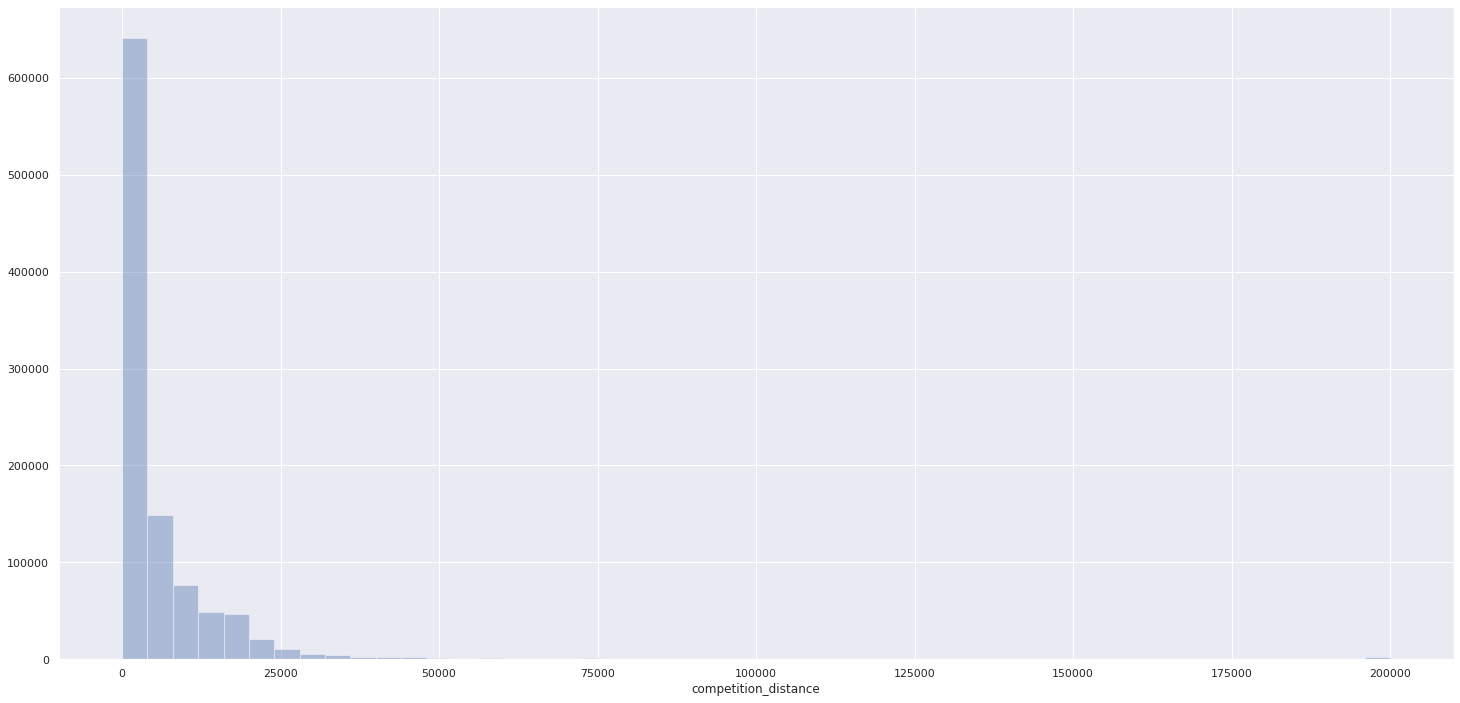

In [19]:
sns.distplot( df1['competition_distance'], kde=False )

## 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

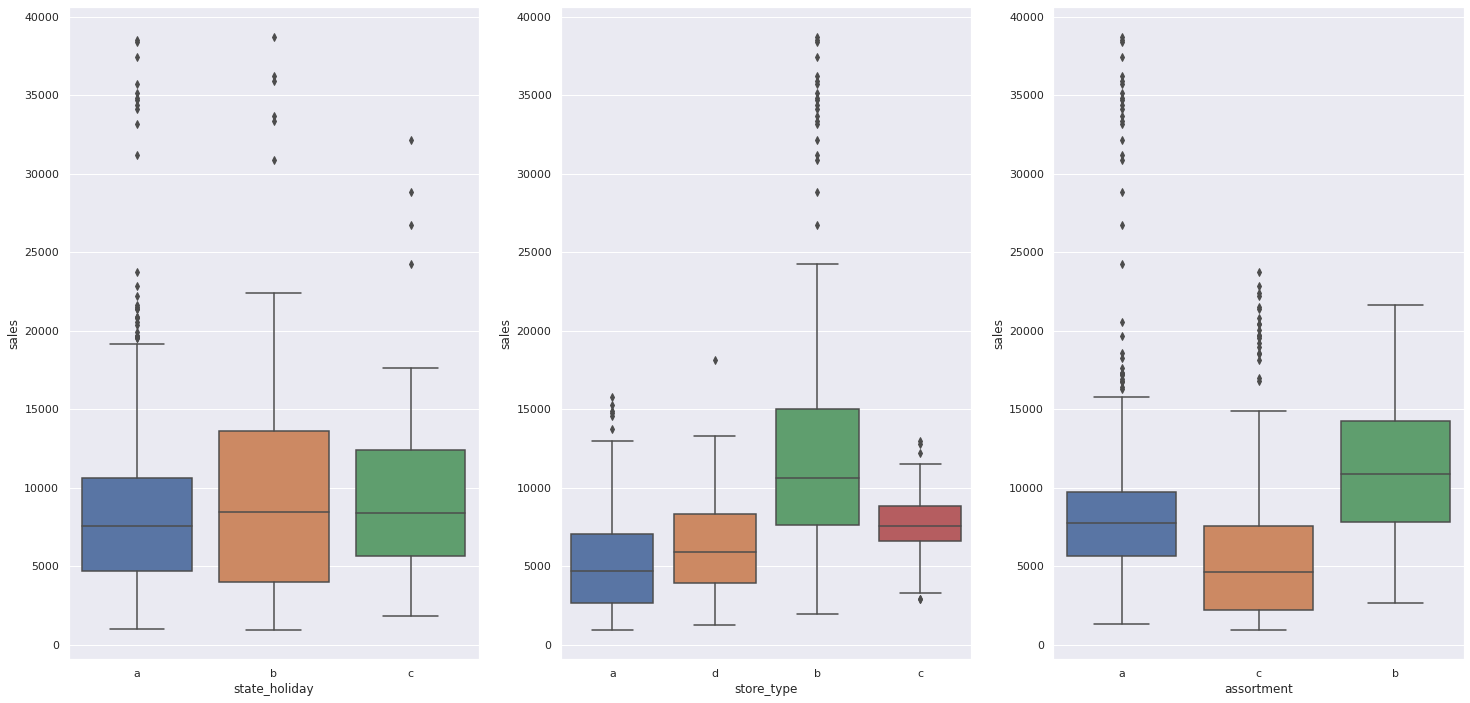

In [21]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 Feature Engineering

## 2.1 Mind Map de Hipóteses

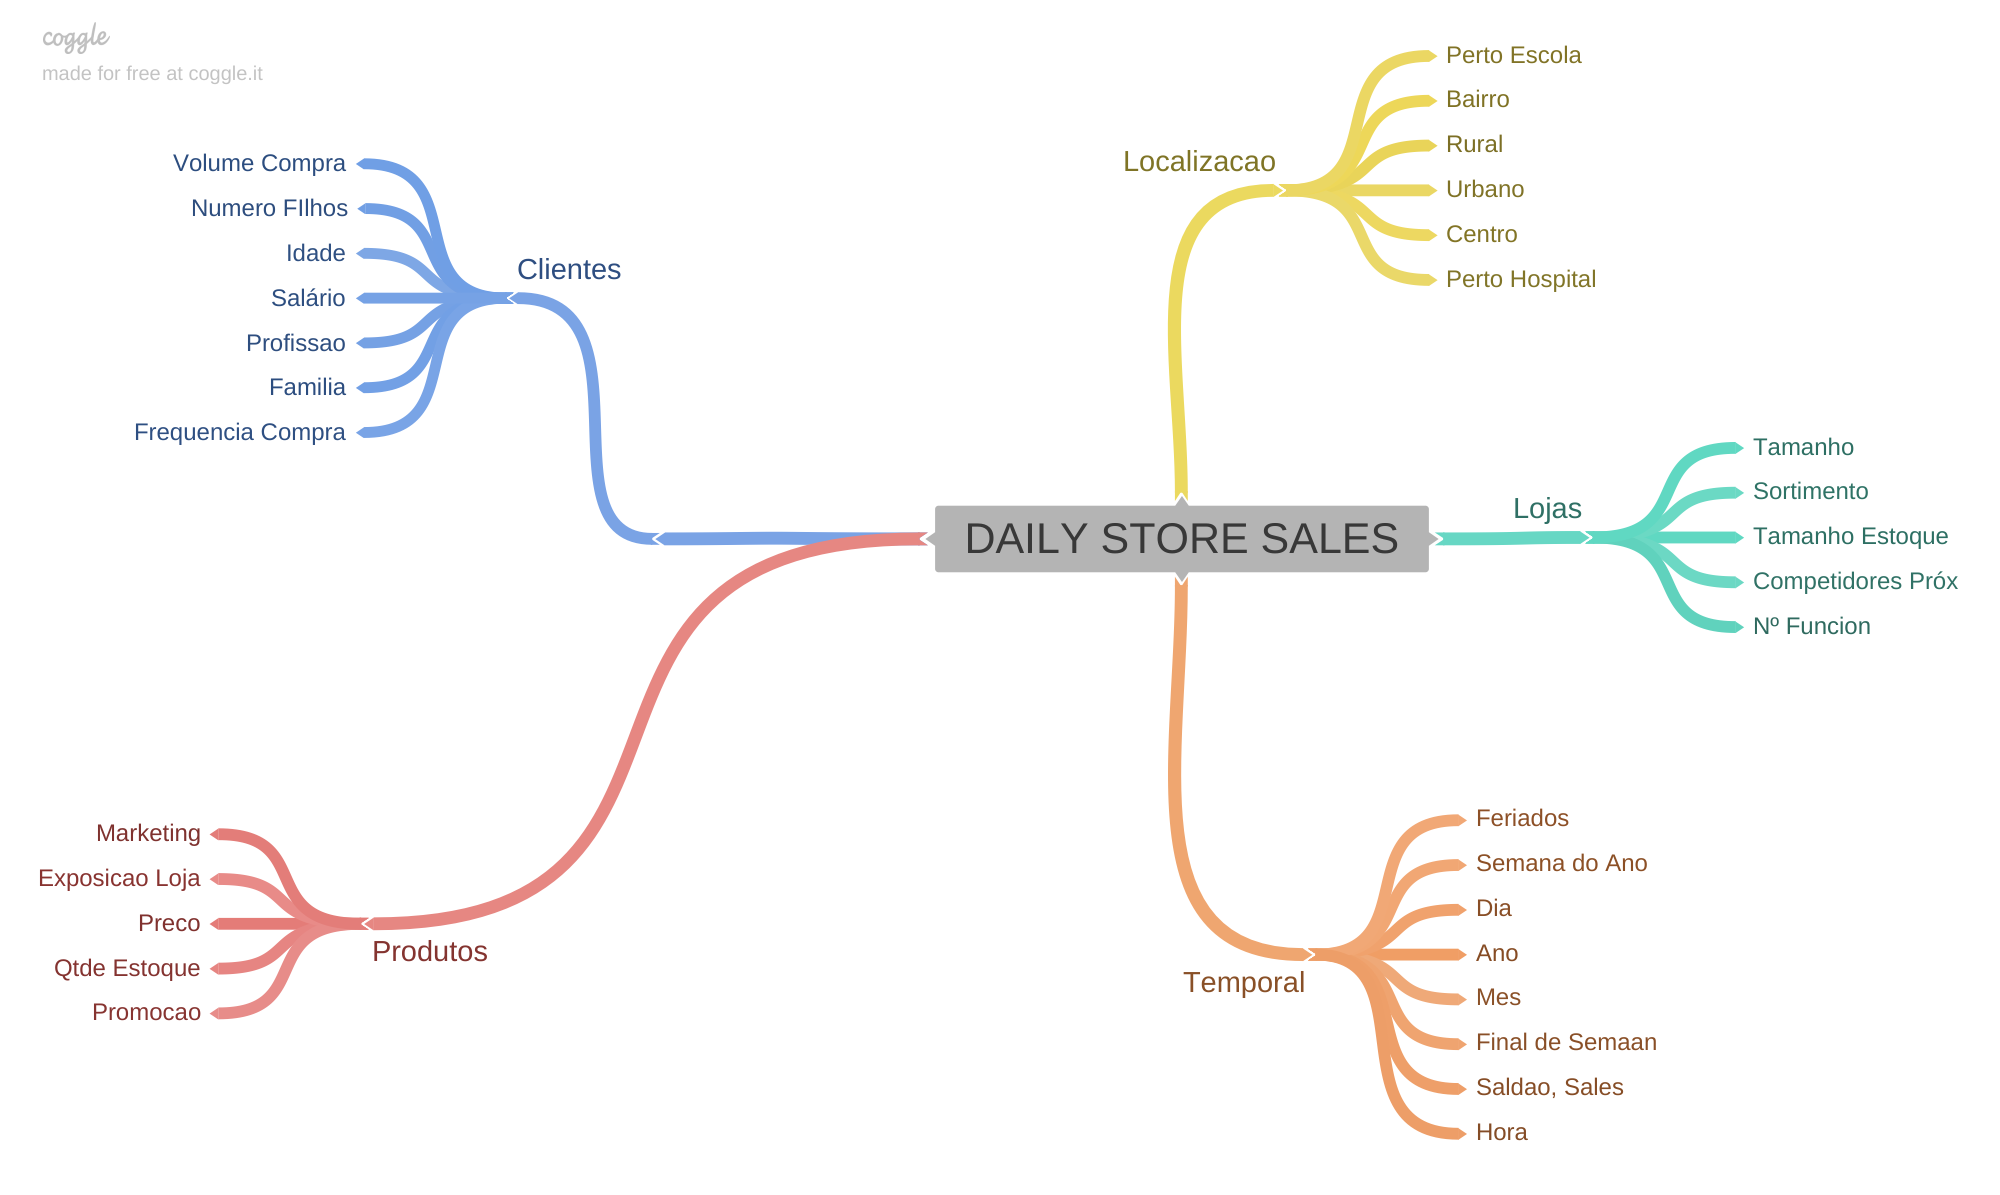

In [22]:
Image('img/Mind_map.png')

## 2.1 Criação de Hipóteses

### 2.1.1 Hipóteses Relacionadas a Loja

**1.** Lojas com maior quadrao de funcionários deveriam vender mais. No

**2.** Lojas com maior estoque deveriam vender mais. No

**3.** Lojas com maior porte deveriam vender mais. No

**4.** Lojas com competidores à mais tempo deveriam vender mais. YES

**5.** Lojas com maior sortimento deveriam vender mais. YES

**6.** Lojas com competidores mais proximos deveriam vender menos. YES

### 2.1.2 Hipóteses Relacionadas ao Produto

**1.** Lojas que investem mais em marketing deveriam vender mais. NO

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais. NO

**3.** Lojas que possuem os precos mais baixos deveriam vender mais. NO

**4.** Lojas que possuem mais promocao(precos menores por mais tempo) deveriam vender mais. NO

**5.** Lojas com promoções mais agressivas(descontos maiores), deveriam vender mais. YES

**6.** Lojas com mais dias de promoção deveriam vender mais. YES

**7.** Lojas com mais promoções consecutivas deveriam vender mais. YES


### 2.1.3 Hipóteses Relacionadas ao Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durantes os feriados escolares.



## 2.2 Lista Final de Hipóteses

**1.** Lojas com competidores à mais tempo deveriam vender mais.

**2.** Lojas com maior sortimento deveriam vender mais.

**3.** Lojas com competidores mais proximos deveriam vender menos. 







**4.** Lojas com promoções mais agressivas(descontos maiores), deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.


**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durantes os feriados escolares.



## 2.3 Feature Engineering


In [23]:
## year
df1['year'] = df1['date'].dt.year

## month
df1['month'] = df1['date'].dt.month

## day
df1['day'] = df1['date'].dt.day

## week of year
df1['week_of_year'] = df1['date'].dt.weekofyear

# year week
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')


df1.head().T
#competition_since
df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df1['competition_time_month'] = ((df1['date'] - df1['competition_since'] ) /30).apply(lambda x: x.days).astype(int)

#promo_since
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df1['promo_time_week'] = ((df1['date'] - df1['promo_since'] ) / 7).apply(lambda x: x.days).astype(int)

#assortment
df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state_holiday
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


# 3.0 Filtragem de Variáveis

In [24]:
df3 = df1.copy()

## 3.1 Filtragem das Linhas


In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [26]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 3.2 Seleção das Colunas

In [27]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop,axis=1)

In [28]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0 EDA (Exploration Data Analysis)

In [29]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

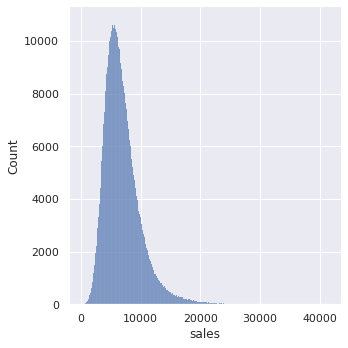

In [30]:
sns.displot(df4['sales'],kde=False);

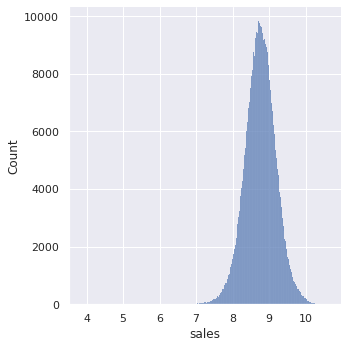

In [31]:
sns.displot(np.log1p(df4['sales']) );

### 4.1.2 Numeric Variables

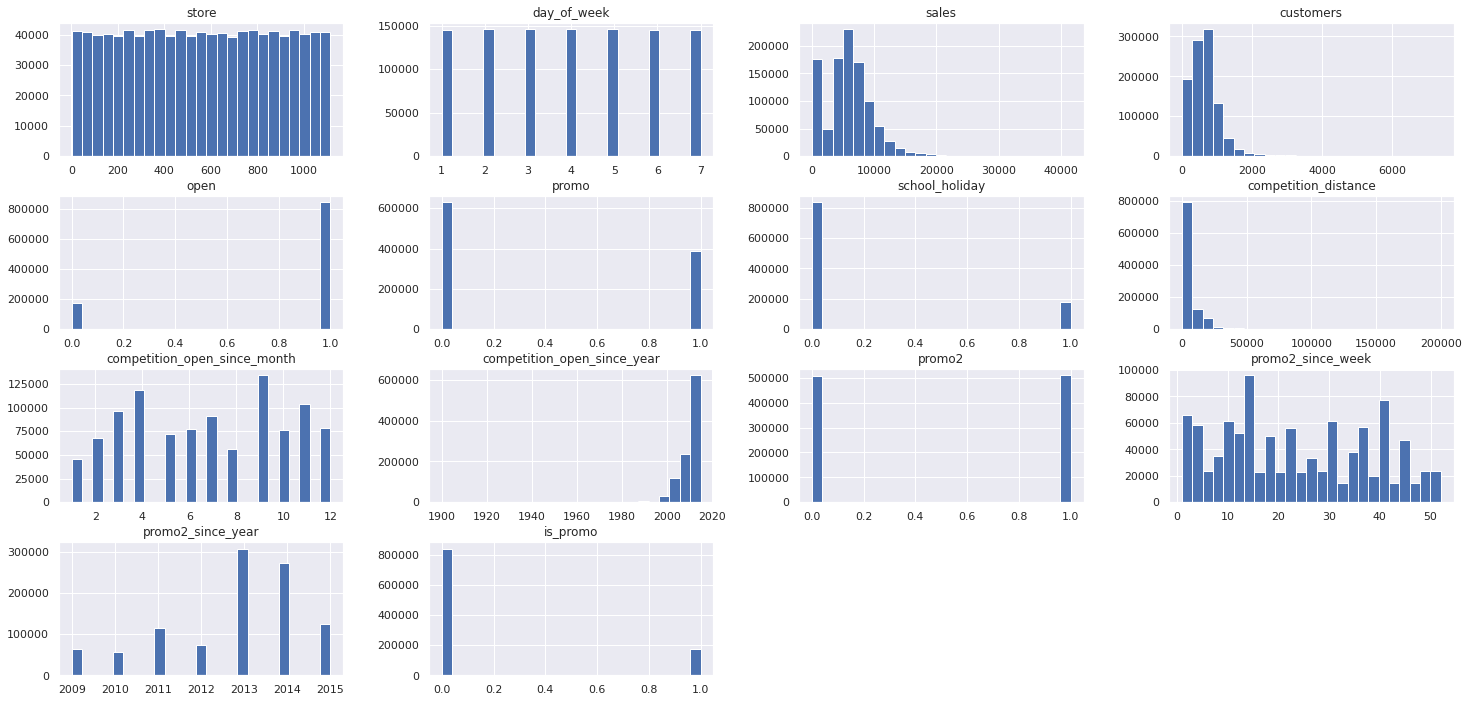

In [32]:
num_attributes.hist(bins=25);

### 4.1.3 Category Variables

In [33]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [34]:
df4['state_holiday'].drop_duplicates()
#df4['store_type'].drop_duplicates()
#df4['assortment'].drop_duplicates()



0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

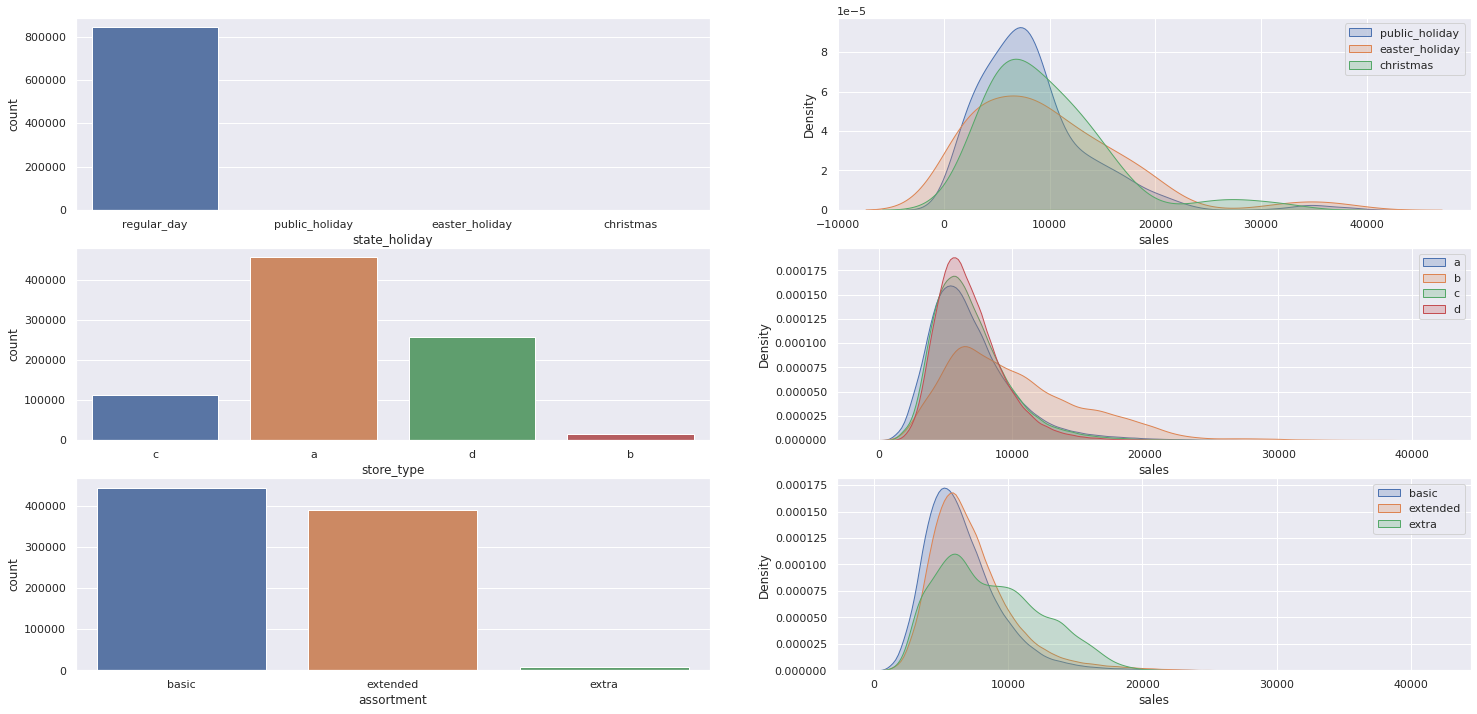

In [35]:
#state_holyday
plt.subplot(3,2,1)

sns.countplot(df4['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas',shade=True)
plt.legend();

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'],label='a',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'],label='b',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'],label='c',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'],label='d',shade=True)
plt.legend();

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'],label='basic',shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'],label='extended',shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'],label='extra',shade=True)
plt.legend();



#store_type
#assortment


## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.

**Falsa** - Lojas com MAIOR SORTIMENTO vendem MENOS.







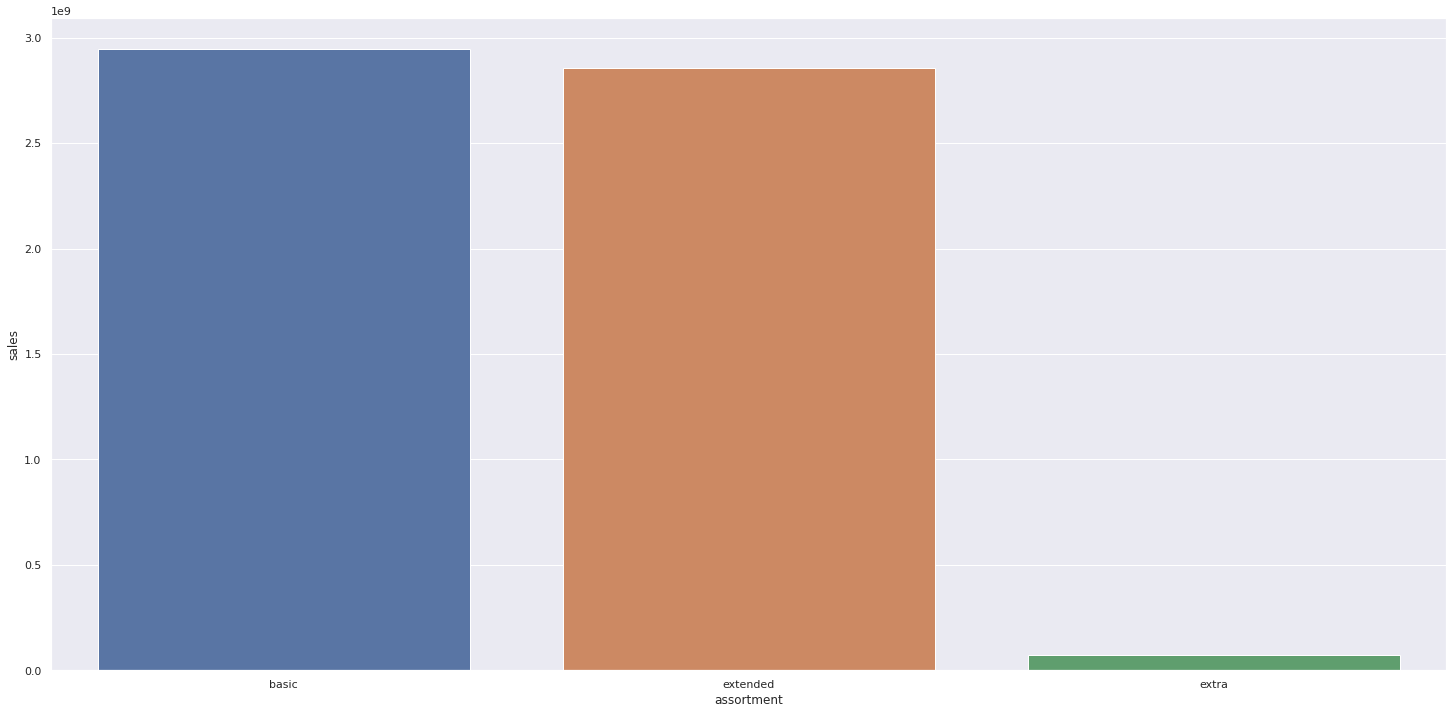

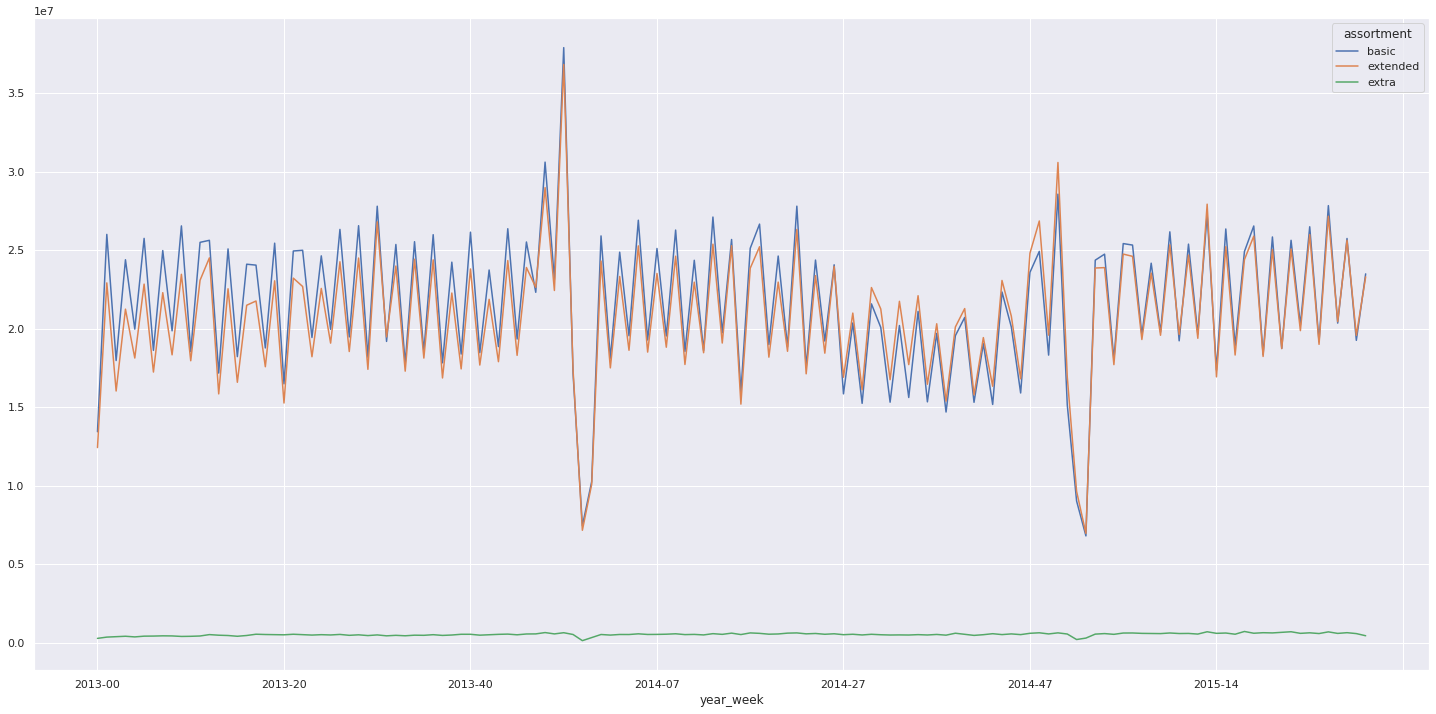

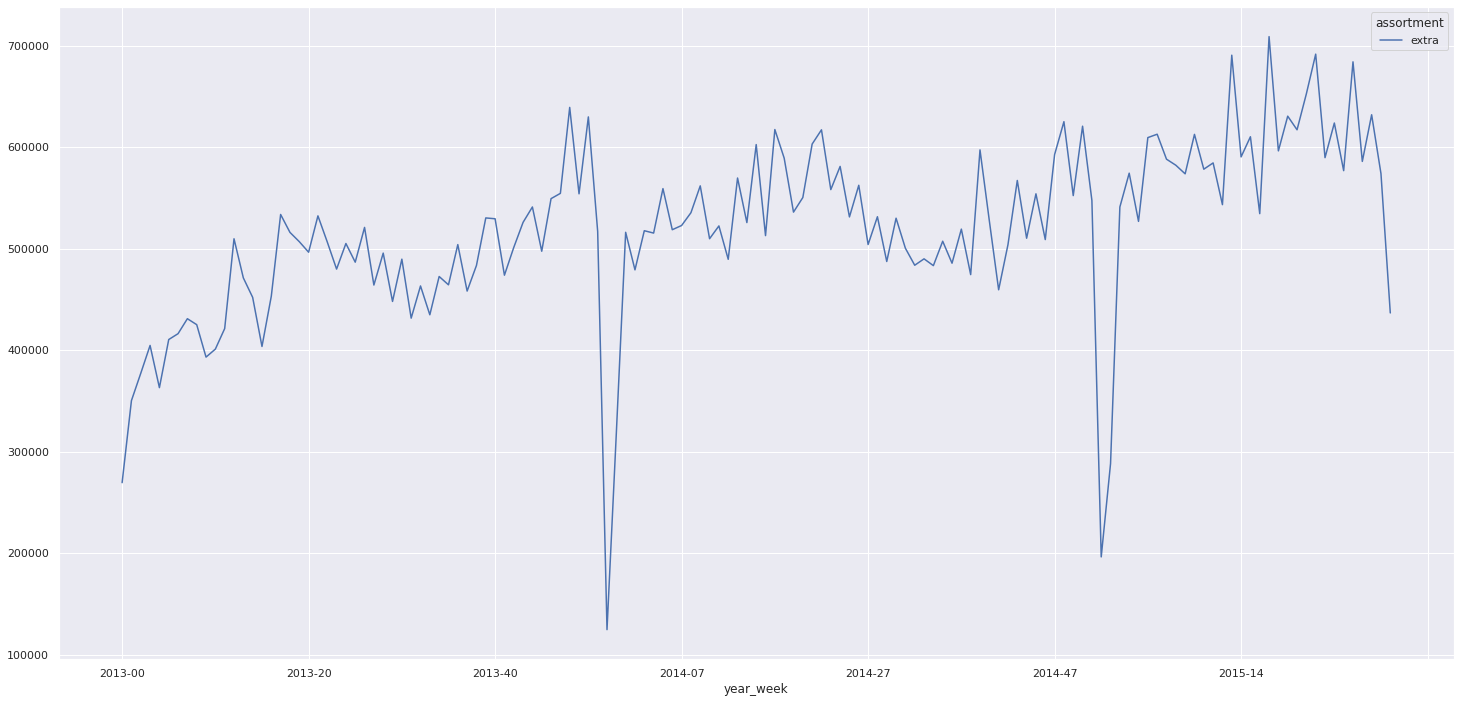

In [36]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot();


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot();


#### REALIZAR GRID PARA PEGAR IMAGEM MELHOR

### **H2.**Lojas com competidores mais proximos deveriam vender menos. 

**Falsa** - Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

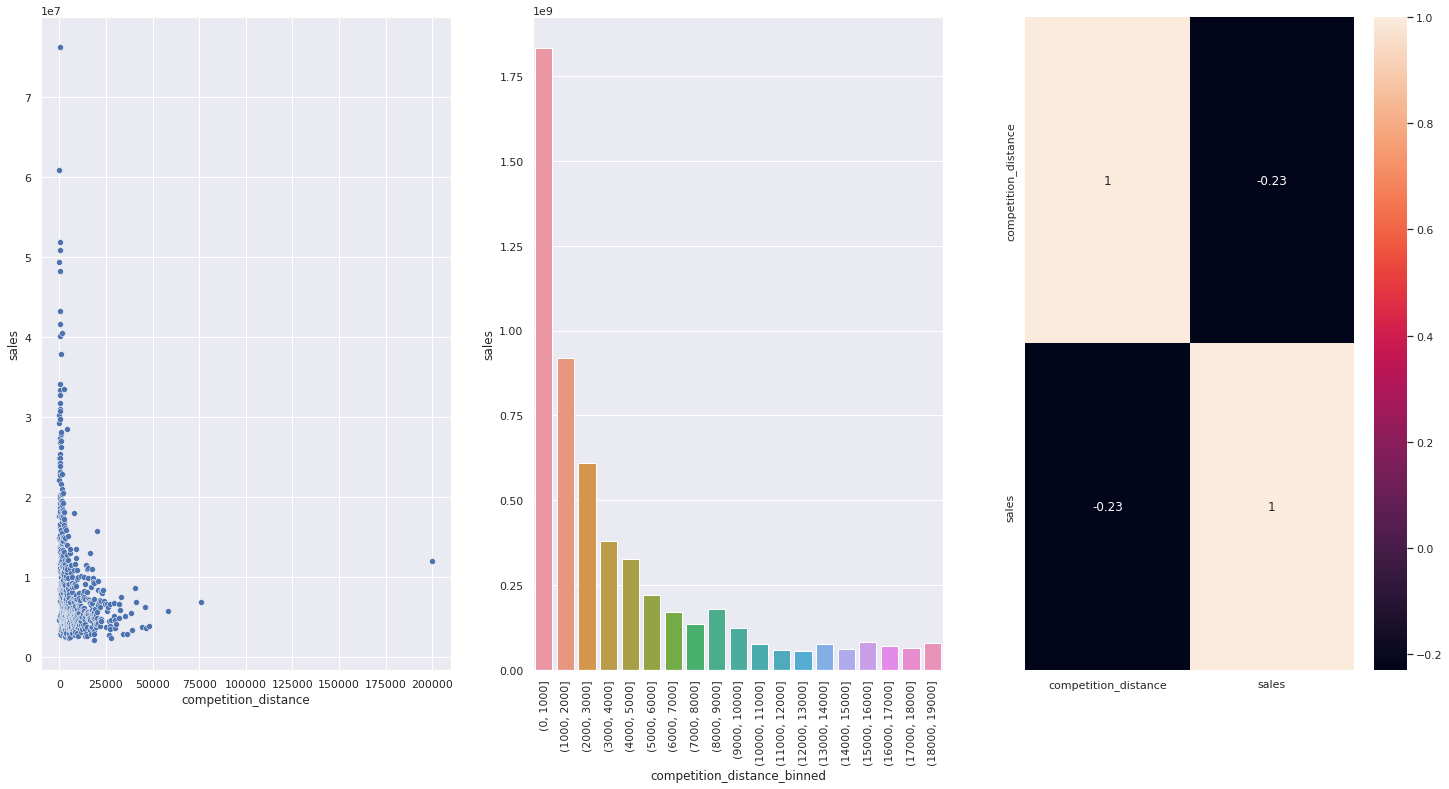

In [37]:
aux5 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux5);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux5['competition_distance_binned'] = pd.cut(aux5['competition_distance'],bins=bins)
aux6 = aux5[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux6);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux5.corr(method='pearson'),annot=True);

### CORRELAÇÃO
# VAI DE O A -1. Quanto mais próxima de 0, mais fraca é a correlação. (-0.2 = Quanto mais distante o meu concorrente -> menor a venda )
#                Quanto mais proxima de -1, mais forte é a correlação.

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**Falsa** - Lojas com competidores a MAIS TEMPO vendem MENOS.

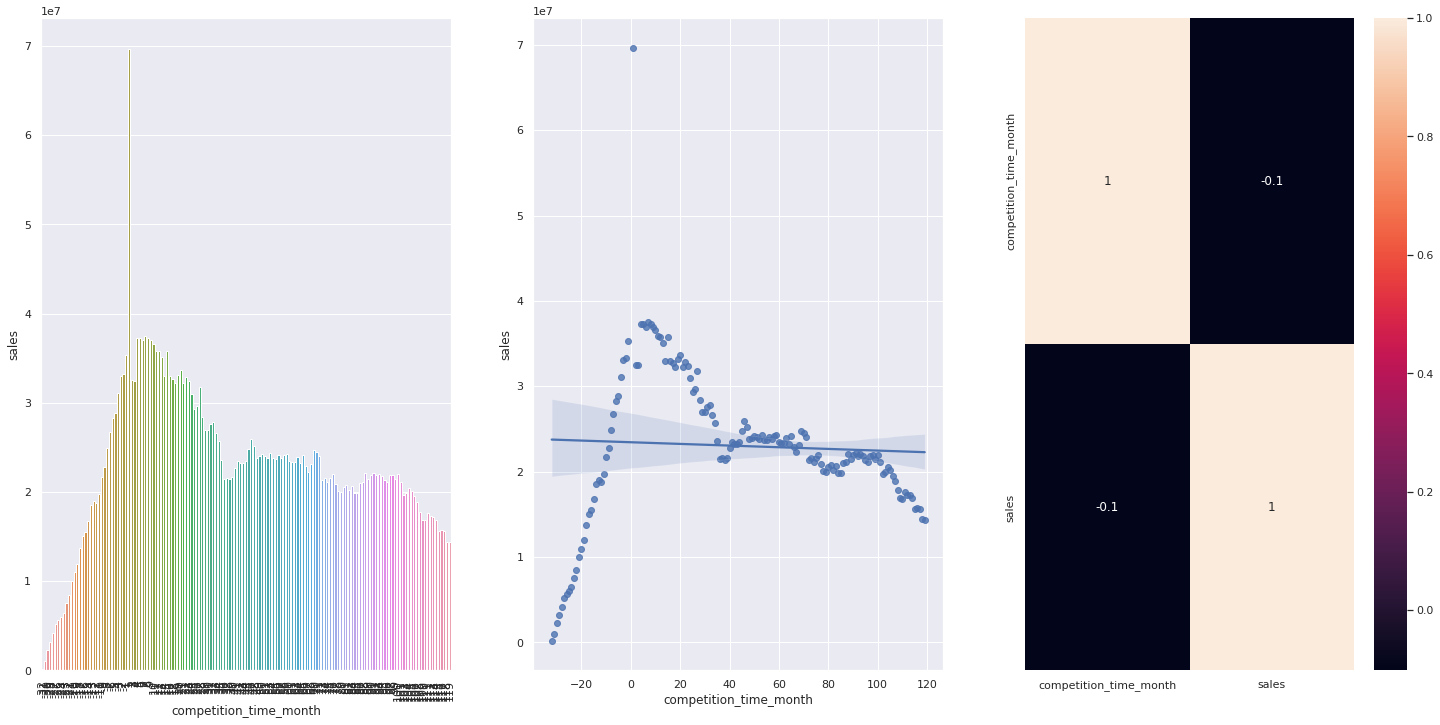

In [38]:
aux7 = df4[['competition_time_month','sales']].groupby(['competition_time_month']).sum().reset_index()
aux8 = aux7[ (aux7['competition_time_month'] < 120) & (aux7['competition_time_month'] != 0)]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux8);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux8);

plt.subplot(1,3,3)
sns.heatmap(aux7.corr(method='pearson'),annot=True);


### **H4.** Lojas com promoções mais ativas por mais tempo deveriam vender mais.
**Falsa** - Ela mantem uma certa qtdade de venda padrao, mas depois de certo tempo decai.

In [39]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

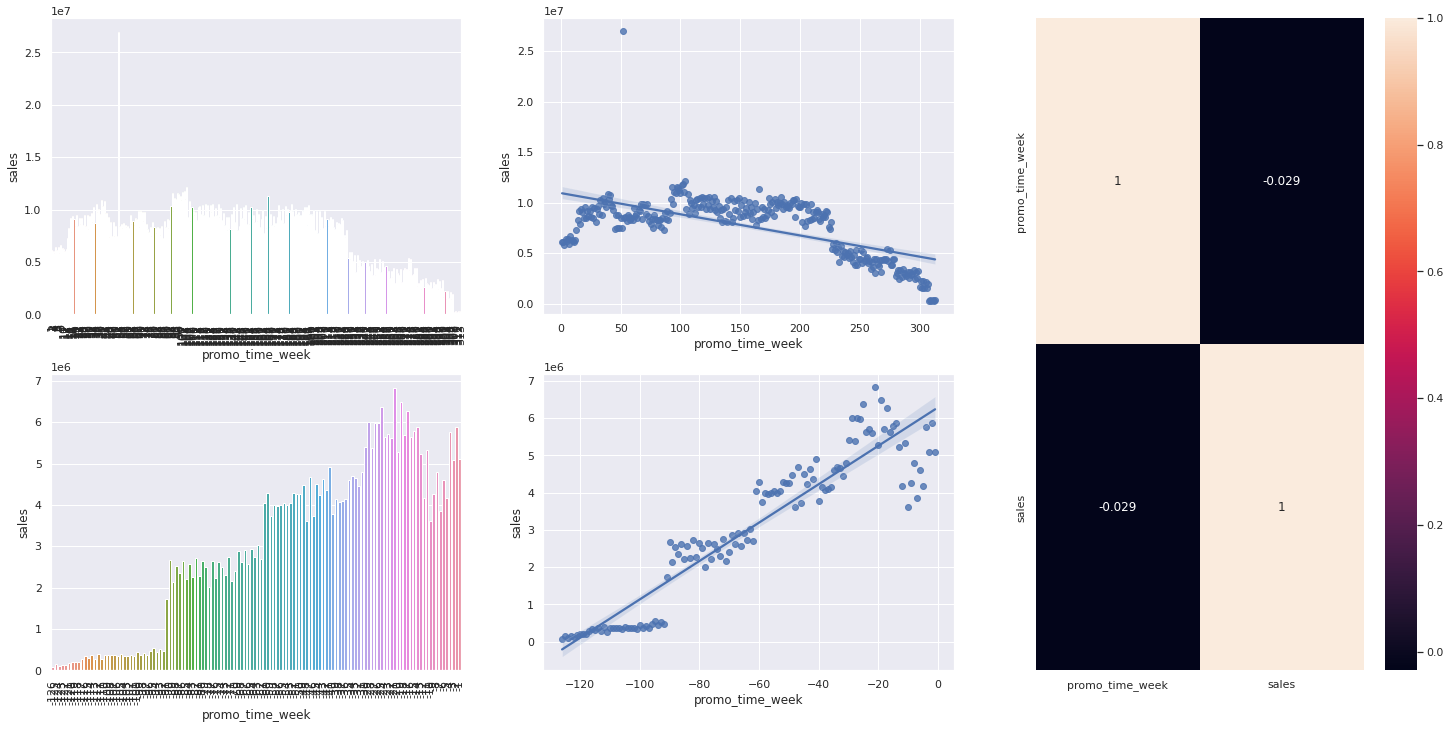

In [40]:
aux9 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

##Periodo Extentido
plt.subplot(grid[0,0])
aux10 = aux9[aux9['promo_time_week'] > 0]
sns.barplot(x='promo_time_week',y='sales',data=aux10);
plt.xticks(rotation=90);

#Periodo Tradicional
plt.subplot(grid[1,0])
aux11 = aux9[aux9['promo_time_week'] < 0]
sns.barplot(x='promo_time_week',y='sales',data=aux11);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux10);
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux11);


plt.subplot(grid[:,2])
sns.heatmap(aux9.corr(method='pearson'),annot=True);


### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>



### **H6.** Lojas com promoções consecutivas deveriam vender mais.
**Falsa** - Lojas com mais promoções consectuvias vendem menos.

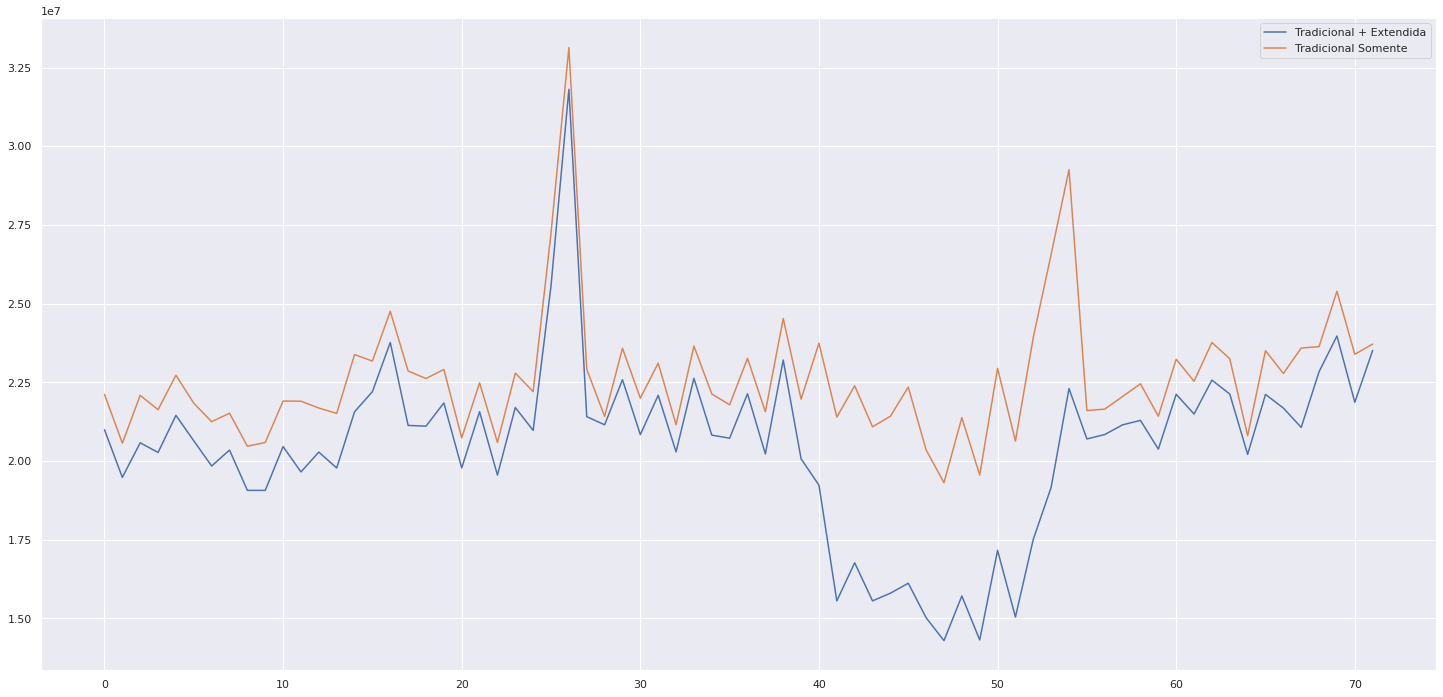

In [41]:
#df4.head()
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

#subplot(1,1,1)
aux10 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux10.plot()

#subplot(1,1,2)
aux11 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux11.plot(ax=ax)

ax.legend(labels=['Tradicional + Extendida','Tradicional Somente']);


### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais
**Falsa** - Lojas vendem MENOS durante o natal

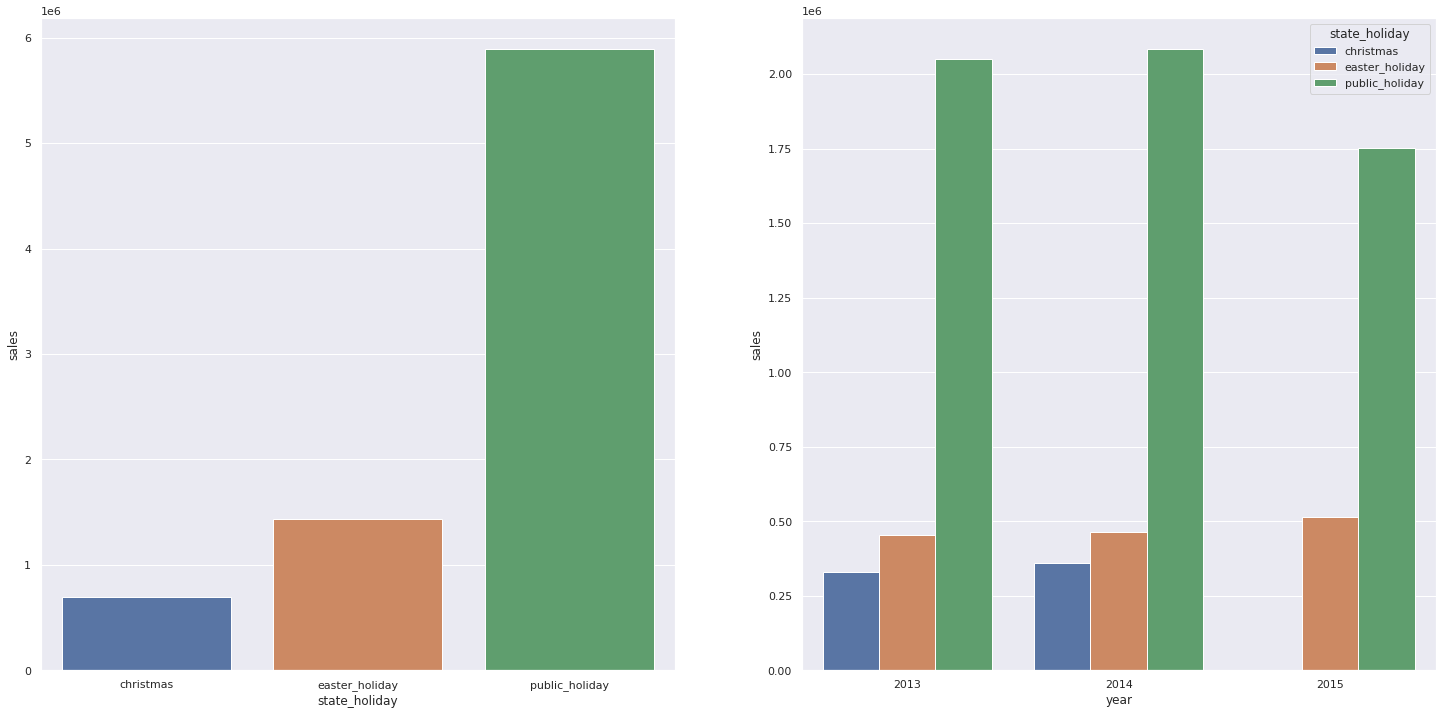

In [42]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);


### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Falsa** - Lojas vendem MENOS ao longo dos anos

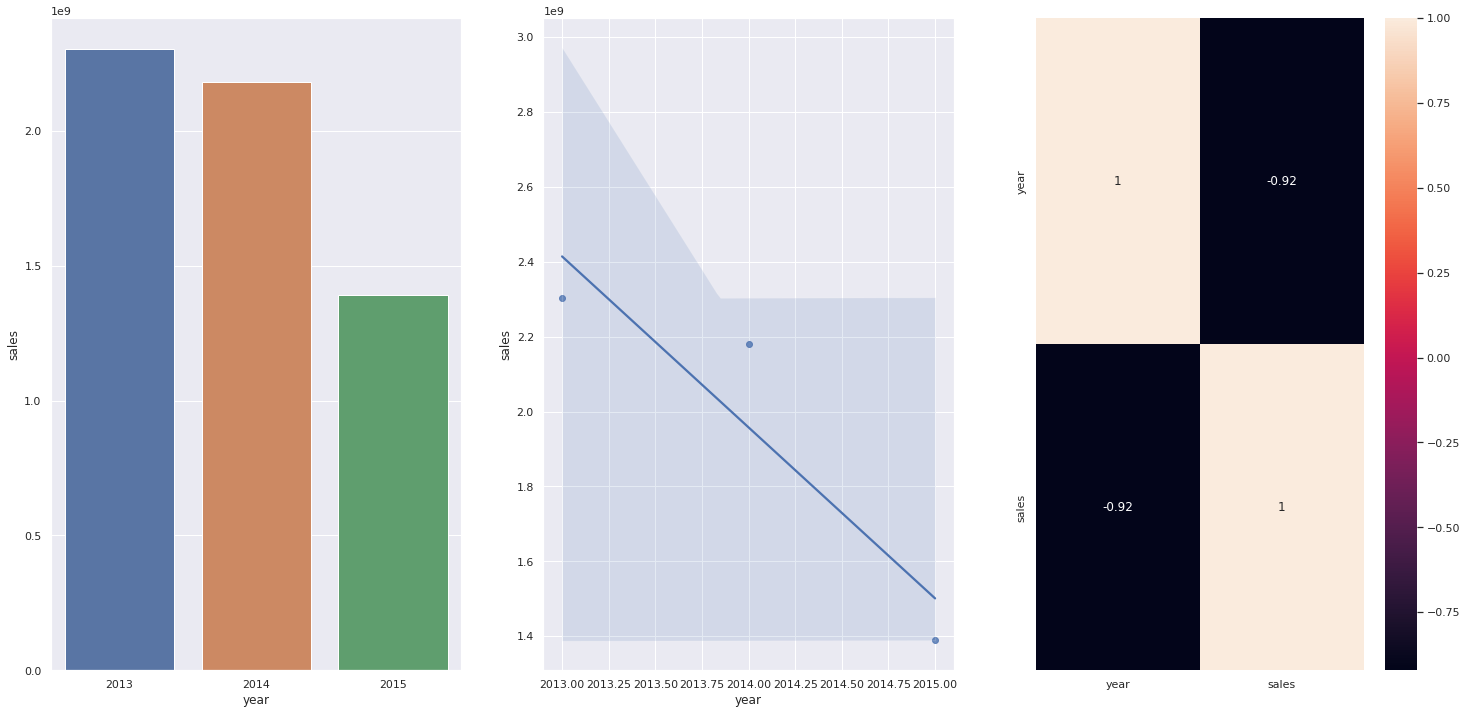

In [43]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);



### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**Falsa** - Lojas vendem MENOS no 2º semestre do ano.

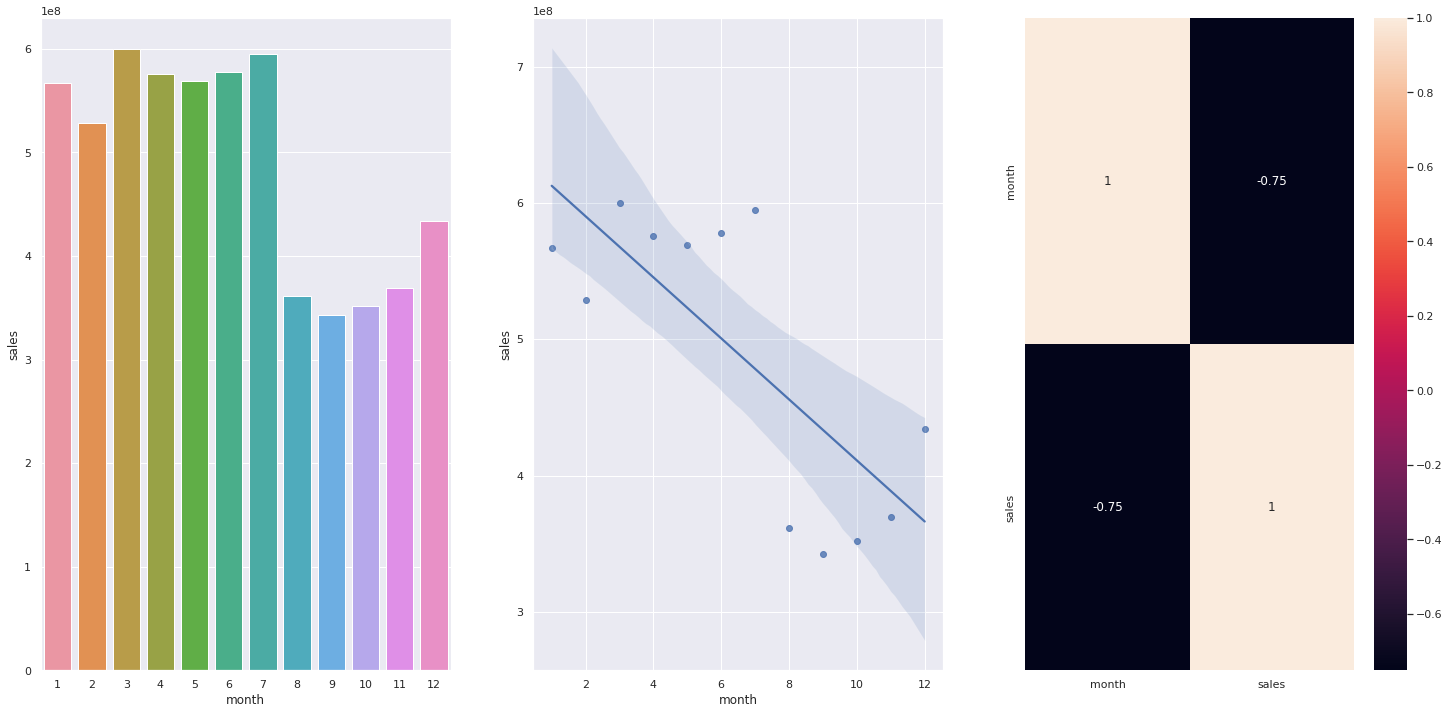

In [44]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);



### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeiro** 


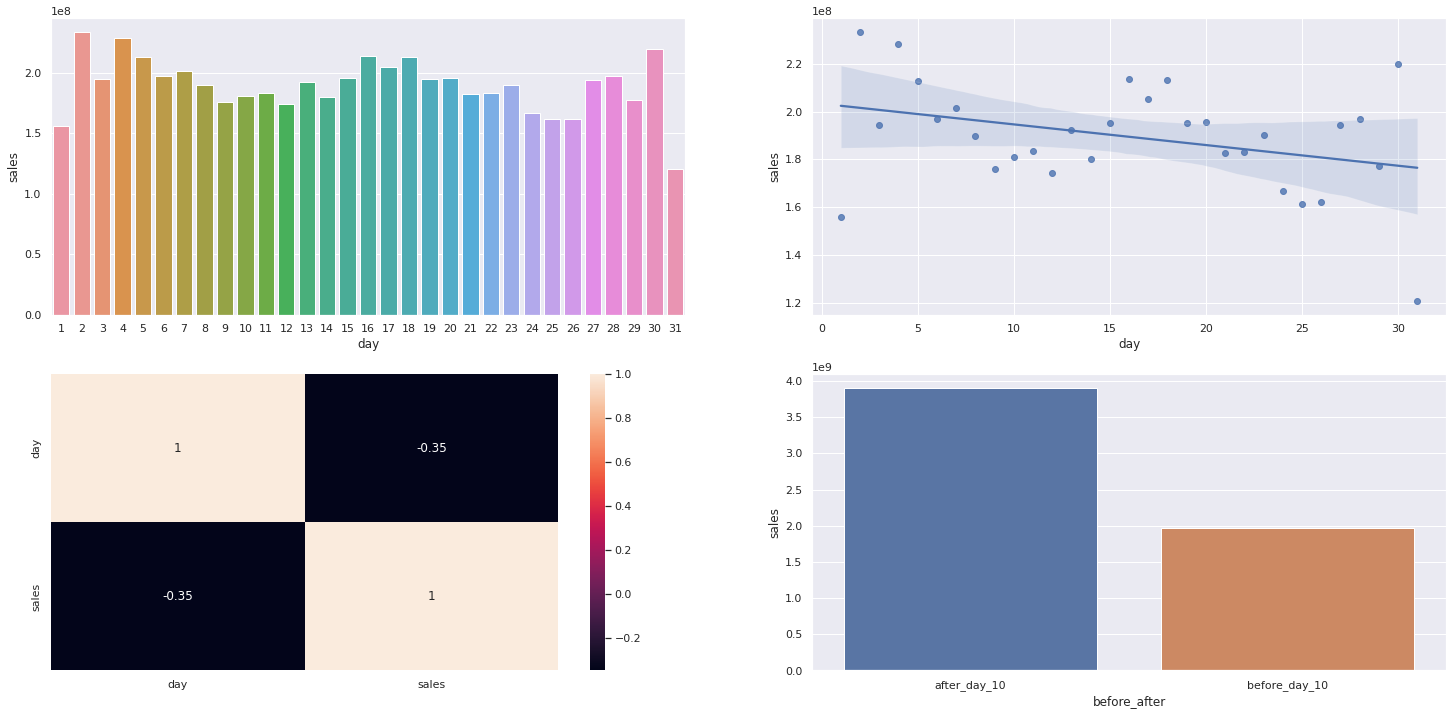

In [45]:

aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_day_10' if x <= 10 else 'after_day_10')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);

                    

### **H11.** Lojas deveriam vender menos aos finais de semana.
**Verdadeiro**


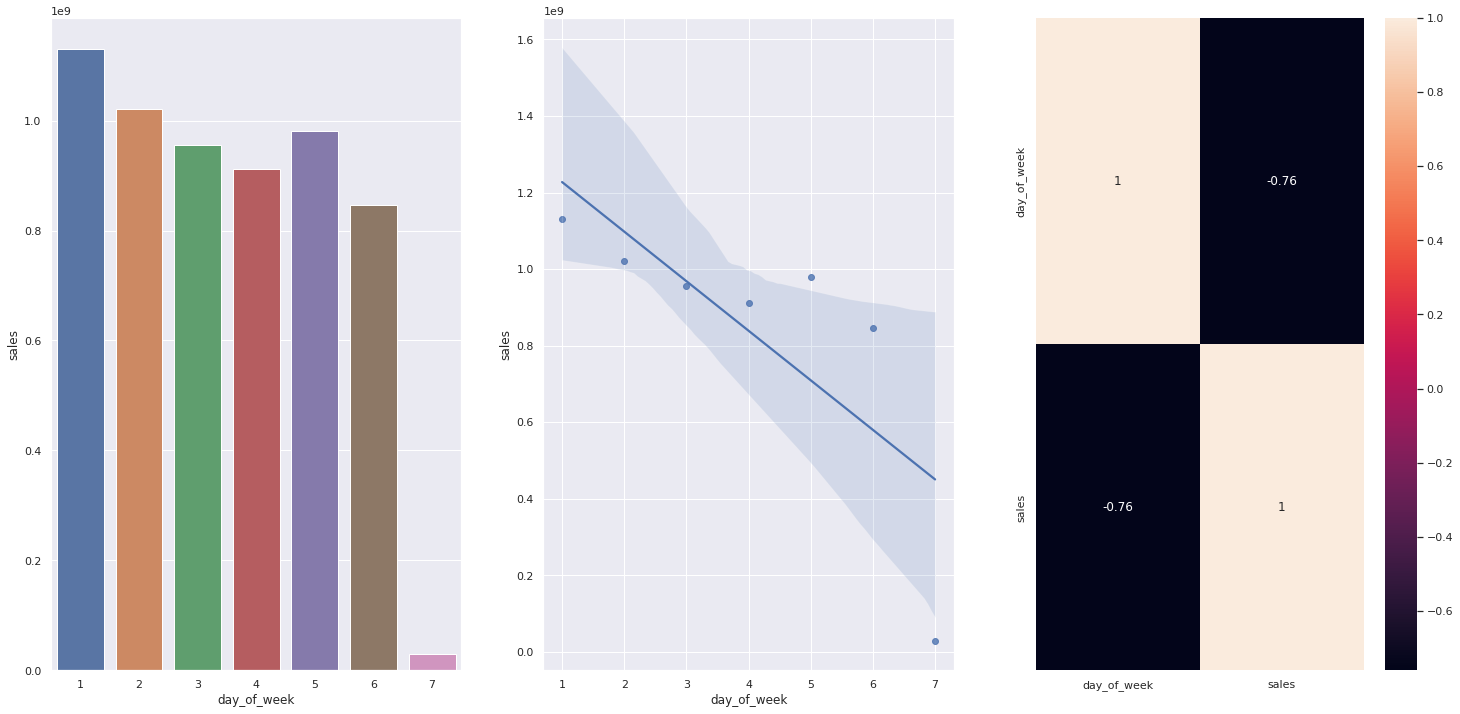

In [46]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);


### **H12.** Lojas deveriam vender menos durantes os feriados escolares.
**Verdadeiro** - Exceto nos meses de férias escolares(julho/agosto)


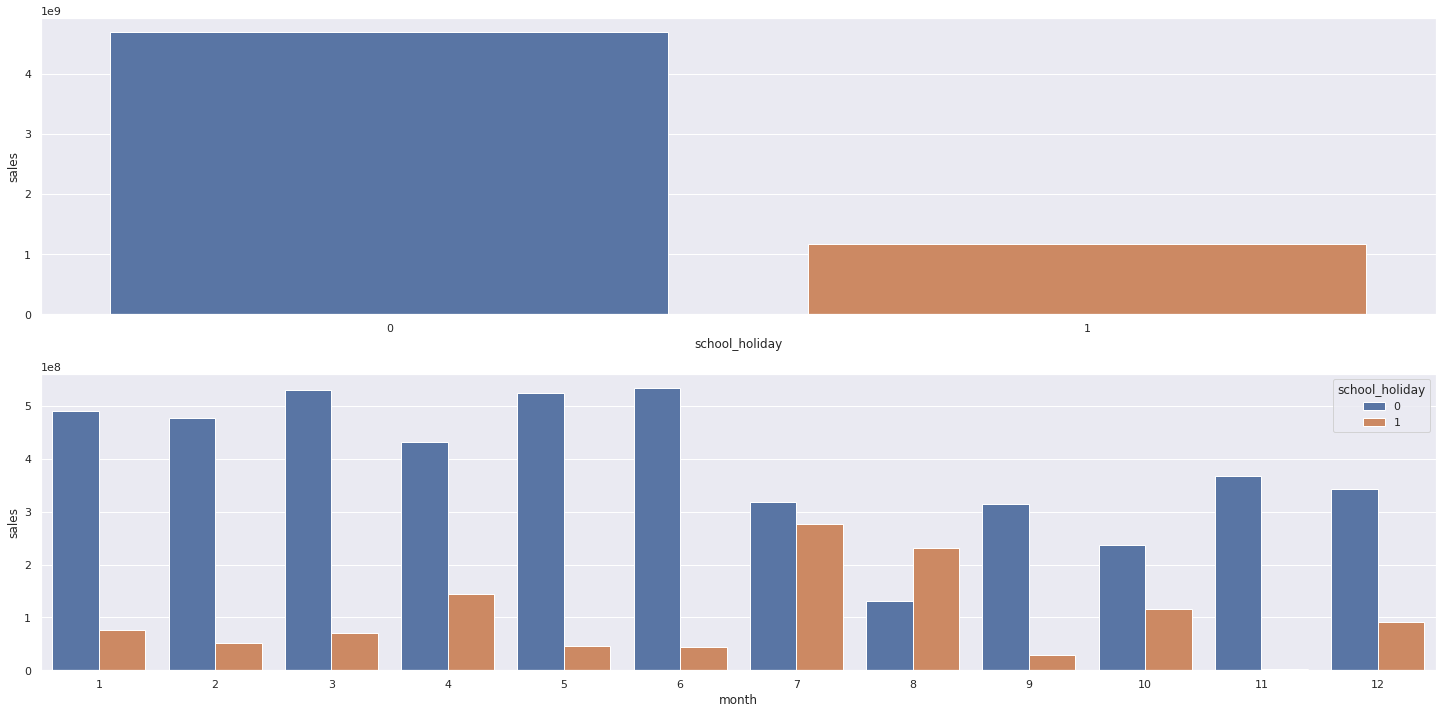

In [47]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday',y='sales',data=aux1);

plt.subplot(2,1,2)
aux2 = aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday', data=aux2);


### 4.2.1 Resumo Das Hipóteses

In [48]:
from tabulate import tabulate
tab = [['Hipoteses','Conclusao','Relevancia'],
    ['H1','Falsa','Baixa'],
    ['H2','Falsa','Media'],
    ['H3','Falsa','Media'],
    ['H4','Falsa','Baixa'],
    ['H5','----' , '----'],
    ['H6','Falsa','Baixa'],
    ['H7','Falsa','Media'],
    ['H8','Falsa','Alta'],
    ['H9','Falsa','Alta'],
    ['H10','Verdadeira','Alta'],
    ['H11','Verdadeira','Alta'],
    ['H12','Verdadeira','Baixa']]


print(tabulate(tab,headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           ----         ----
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

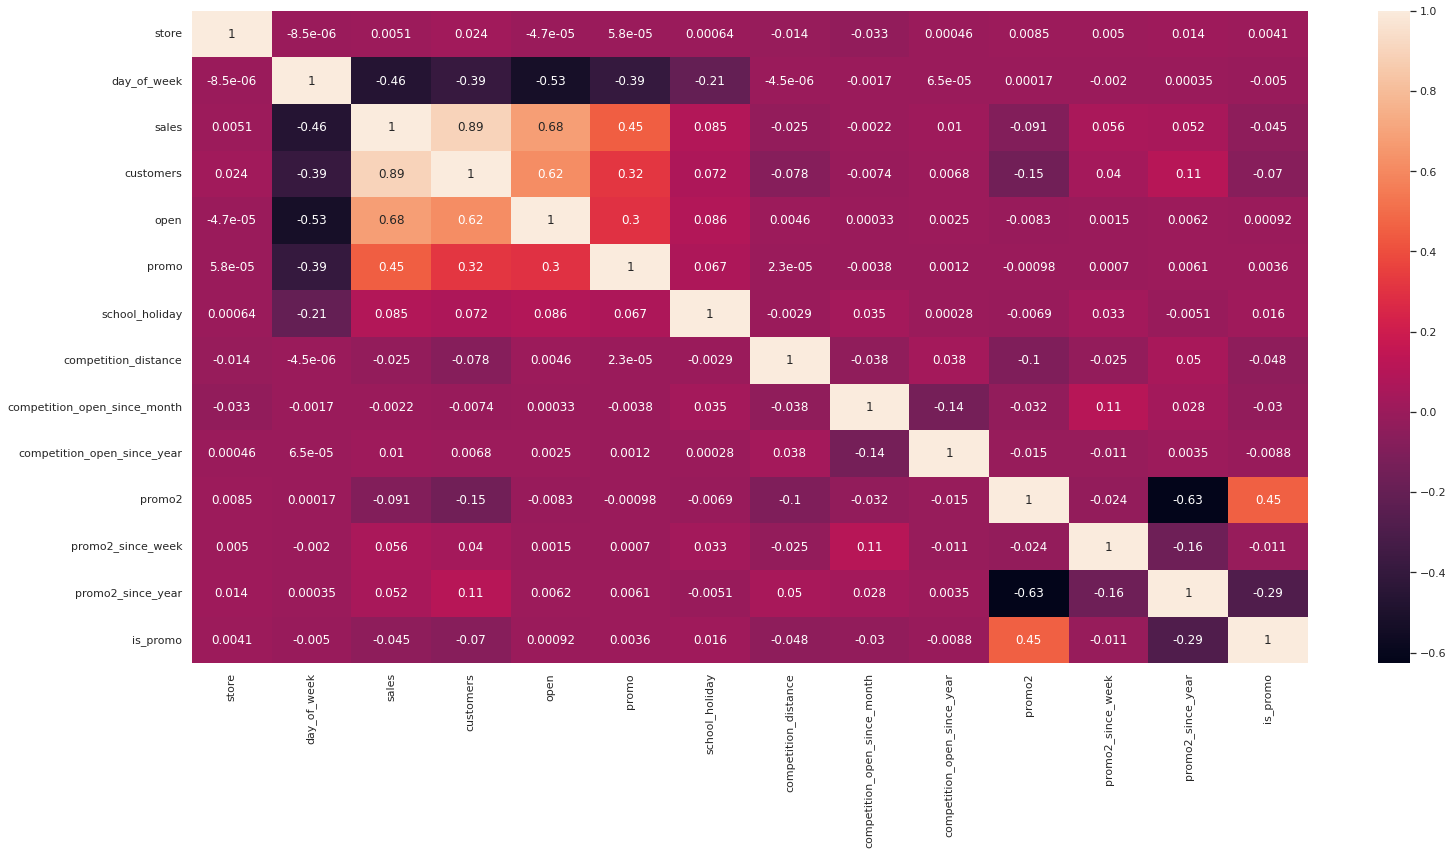

In [49]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

## Quanto mais perto do preto  - Maior é a correlação negativa
## Quanto mais perto do branco - Maior é a correlação positiva

### 4.3.2 Categorical Attributes

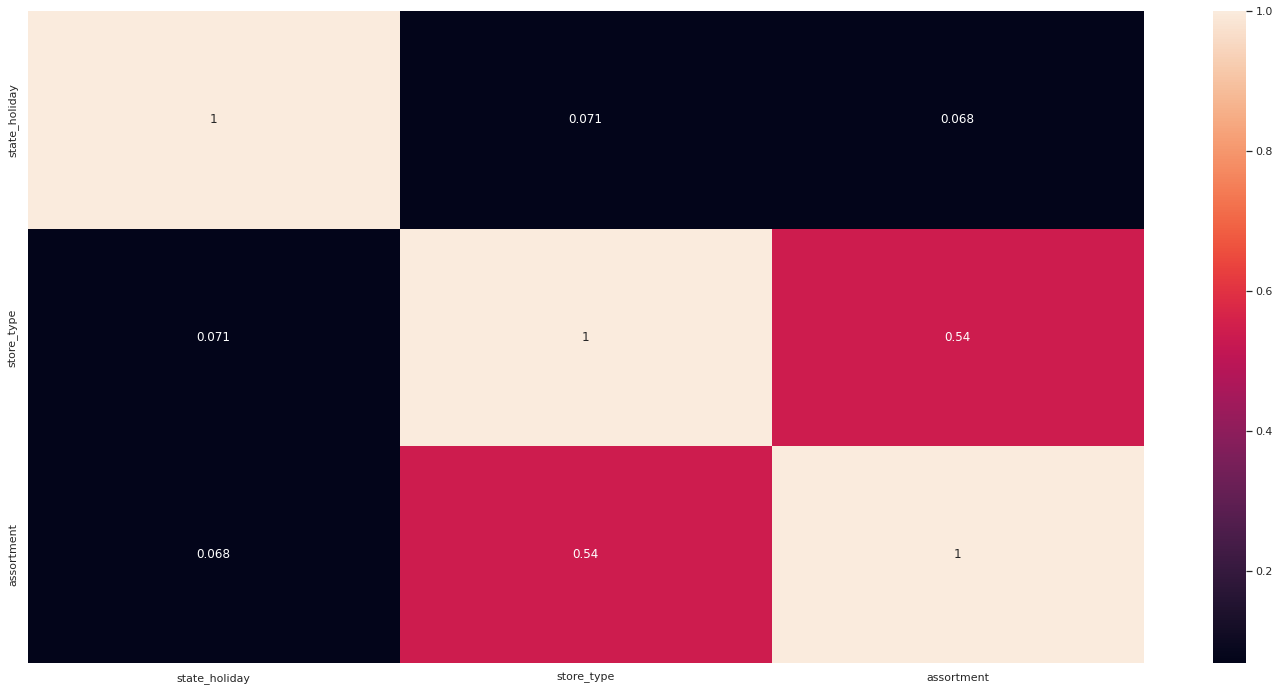

In [50]:
#Only Categorical Attributes 
a = df4.select_dtypes(include='object')

#Calculate Cramer V
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

#Final Datraset
d = pd.DataFrame( {'state_holiday':[a1,a2,a3],
               'store_type':[a4,a5,a6],
               'assortment':[a7,a8,a9]})
d = d.set_index(d.columns)

sns.heatmap(d,annot=True);

# 5.0 Data Preparation

In [51]:
df5 = df4.copy()

## 5.1 Normalização 

In [52]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.2 Reescaling

In [53]:
m

,attributes,min,max,range,media,mediana,desvio_padrao,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [54]:
a = df5.select_dtypes(include=['int64','float64'])

In [55]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [56]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance - ROBUST SCALLER
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs,open('parameter/encoding_competition_distance_scaler.pkl','wb'))

# competition_time_month - ROBUST SCALLER
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs,open('parameter/encoding_competition_time_month_scaler.pkl','wb'))

# promo_time_week -  MIN MAX - MinMaxScaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms,open('parameter/encoding_promo_time_week_scaler.pkl','wb'))

# year - MIN MAX
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms,open('parameter/encoding_year_scaler.pkl','wb'))



## 5.3 Transformação

### 5.3.1 Encoding

In [57]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [58]:
#state_holiday - regular / public / easter / christmas - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

#store_type - a b c -> Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le,open('parameter/store_type_scaler.pkl','wb'))

#assortment -> basic - extended - extra -> Ordinal Encoding
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2 Response Variable Transformation

<AxesSubplot:xlabel='sales', ylabel='Density'>

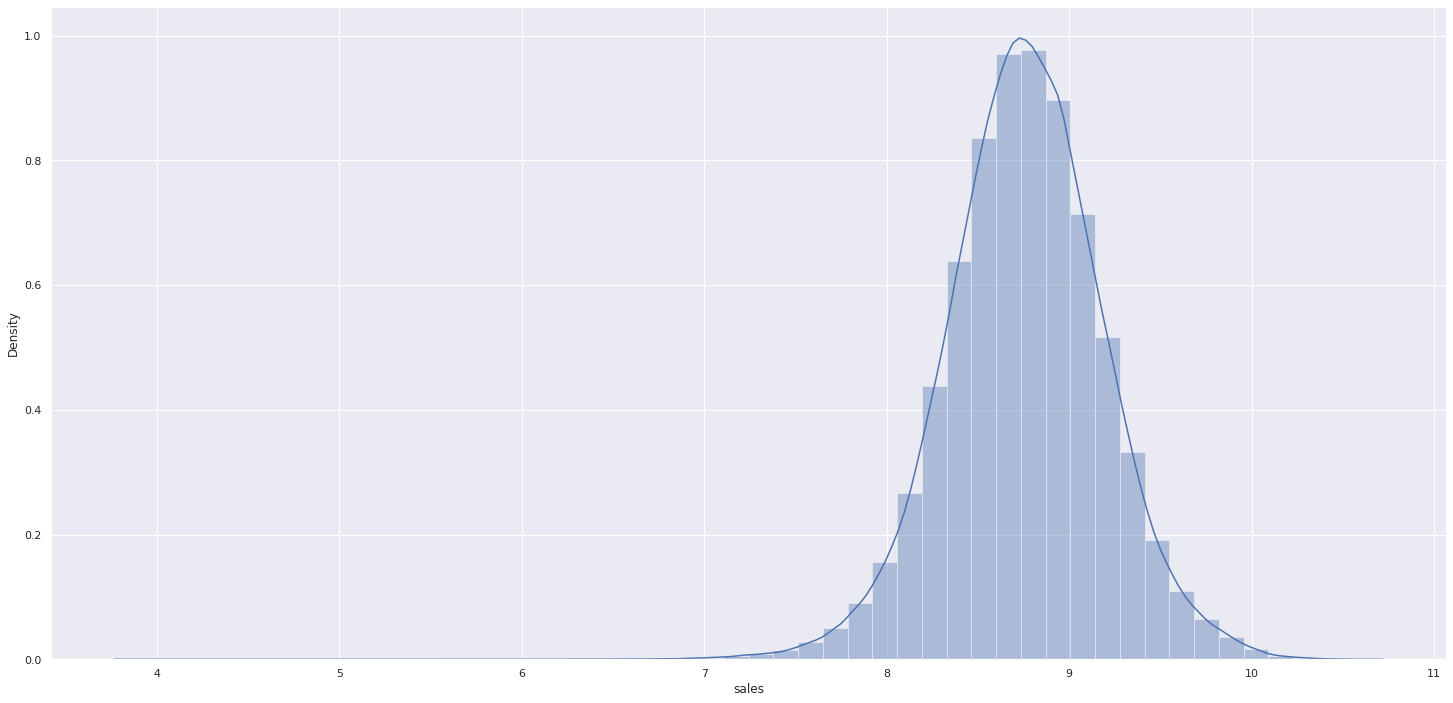

In [59]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [60]:
## month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2* np.pi/12)) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2* np.pi/12)) )

## day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2* np.pi/30)) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2* np.pi/30)) )


## week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2* np.pi/52)) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2* np.pi/52)) )

## day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2* np.pi/7)) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2* np.pi/7)) )



In [61]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 Feature Selection

In [62]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [111]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(columns=cols_drop,axis=1)

In [63]:
#df6[['store','date']].groupby('store').min().reset_index()
#2013-01-02 - min data

#df6[['store','date']].groupby('store').max().reset_index()
#2015-07-31 - max data

df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
# = ('2015-06-19 00:00:00')

#Training Dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Test Dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']


print('Training Min Date: {}'.format(x_train['date'].min() ) )
print('Training Max Date: {}'.format(x_train['date'].max() ) )

print('\nTest Min Date: {}'.format(x_test['date'].min() ) )
print('Test Max Date: {}'.format(x_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [66]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [67]:
x_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,...,0,1,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969


In [68]:
x_train_n = x_train.drop(['date','sales'],axis=1).values
y_train_n = y_train.values.ravel()

#define random forest regressor
#rf = RandomForestRegressor(n_jobs=-1)

#define boruta
#boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

### 6.2.1 Best Features from Boruta

In [69]:
#cols_selected = boruta.support_.tolist()

#Best Features
x_train_fs = x_train.drop(['date','sales'],axis=1)
cols_selected_boruta = x_train_fs.iloc[:,cols_selected ].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

NameError: name 'cols_selected' is not defined

In [70]:
cols_final = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',              
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

## 6.3 Manual Features

In [64]:
cols_final = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',              
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

#columns to add 
feat_to_add = ['date','sales']

#final features

cols_final_full = cols_final.copy()
cols_final_full.extend(feat_to_add)


In [72]:
cols_final

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0 Machine Learning Modelling

In [65]:
#df7 = df6.copy()

X_train = x_train[cols_final]
X_test = x_test[cols_final]

# Time Series Data Preparation
x_training = x_train[cols_final_full]

## 7.1 Average Model

In [192]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

#Prediction
aux2 =  aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')

yhat_baseline = aux1['predictions']

#Perfomance
baseline_result = m1_error('Average Model',np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


In [193]:
#AVG MODEL Prediction
aux1['predictions'] = np.expm1(aux1['predictions'])
avg_model_predict = aux1['predictions'].sum()
print('R${:,.2f}'.format(avg_model_predict))

R$280,754,389.45


## 7.2 Linear Regression Model

In [75]:
# Model
lr = LinearRegression().fit(X_train,y_train)

# Prediction
yhat_lr = lr.predict(X_test)

# Perfomance
lr_result = m1_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression model - Cross Validation

In [76]:
lr_result_cv = cross_validation(x_training,5,'Linear Regression',lr,verbose=False)

In [77]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [78]:
# Model
lrr = Lasso(alpha=0.01).fit(X_train,y_train)

# Prediction
yhat_lrr = lrr.predict(X_test)

# Perfomance
lrr_result = m1_error('Linear Regression Regularized - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Linear Regression Regularized - Cross Validation

In [79]:
lrr_result_cv = cross_validation(x_training,5,'Linear Regression Regularized',lrr,verbose=False)

In [80]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regression

In [81]:
# Model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(X_train,y_train)

# Prediction
yhat_rf = rf.predict(X_test)

# Perfomance
rf_result = m1_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.098387,0.099882,1009.869873


### 7.4.1 Random Forest Regression - Cross Validation

In [82]:
rf_result_cv = cross_validation(x_training,5,'Random Forest Regression',rf,verbose=False)

In [83]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regression,837.47 +/- 218.61,0.12 +/- 0.02,1257.22 +/- 319.82


In [ ]:
rf_result_cv

## 7.5 XGBoost Regressor - SELECTED

In [115]:
# Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.3,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(X_train,y_train)

# Prediction
yhat_xgb = model_xgb.predict(X_test)

# Perfomance
xgb_result = m1_error('XGB Regressor',np.expm1(y_test),np.expm1(yhat_xgb))


In [116]:
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,711.31991,0.103848,1026.422526


### 7.5.1 XGBoost Regressor  - Cross Validation

In [117]:
xgb_result_cv = cross_validation(x_training,5,'XGBoostModel_Regressor',model_xgb,verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [118]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoostModel_Regressor,923.71 +/- 150.9,0.13 +/- 0.01,1323.78 +/- 214.82


In [ ]:
xgb_result_cv

## 7.6 Compare Models Perfomance

### 7.6.1 Single Perfomance

In [88]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.098387,0.099882,1009.869873
0,XGB Regressor,711.319910,0.103848,1026.422526
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Regularized - Lasso,1891.704880,0.289106,2744.451735


### 7.6.2 Real Perfomance - Cross Validation

In [89]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regression,837.47 +/- 218.61,0.12 +/- 0.02,1257.22 +/- 319.82
0,XGBoomodel_xgbgbssor,923.71 +/- 150.9,0.13 +/- 0.01,1323.78 +/- 214.82
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression Regularized,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0 Hyper-Parameter Fine Tuning 

## 8.1 RandomSearch 

In [100]:
# param = {'n_estimators': [2000],
#          'eta': [0.3],
#          'max_depth': [5],
#          'subsample': [0.7],
#          'colsample_bytree': [0.9],
#          'min_child_weigth': [8]}

# MAX_EVAL = 1

In [ ]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     #CHOOSE values for parameters randomly
#     hp = {k: random.sample(v,1)[0] for k, v in param.items() }
#     print(hp)
    
#     # Model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weigth=hp['min_child_weigth'])

#     # Prediction
#     #yhat_xgb = model_xgb.predict(X_test)

#     # Perfomance
#     #xgb_result = m1_error('XGB Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
#     #xgb_result

#     result = cross_validation(x_training,5,'XGBooster Regressor CV ',model_xgb,verbose=True)
#     final_result = pd.concat([final_result,result])

# final_result


## 8.2 Final Model 

In [67]:
 param_tuned = {'n_estimators': 2500,
          'eta':0.1,
          'max_depth': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.9,
          'min_child_weigth': 8}

In [68]:
# # model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=param_tuned['n_estimators'],
                                 eta=param_tuned['eta'],
                                 max_depth=param_tuned['max_depth'],
                                 subsample=param_tuned['subsample'],
                                 colsample_bytree=param_tuned['colsample_bytree'],
                                 min_child_weigth=param_tuned['min_child_weigth']).fit(X_train,y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)

# Perfomance
xgb_result_tuned = m1_error('XGB Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

[18:41:20] WARNING: ../src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,666.343734,0.098156,964.36841


In [124]:
xgb_result_tuned_cv = cross_validation(x_train,5,'XGboost Regressor CV ',model_xgb_tuned,verbose=True)
xgb_result_tuned_cv


KFold Number: 5
[14:18:05] WARNING: ../src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 4
[14:23:28] WARNING: ../src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 3
[14:29:11] WARNING: ../src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly pa

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGboost Regressor CV,887.49 +/- 148.25,0.13 +/- 0.02,1253.53 +/- 203.62


In [ ]:
#pickle.dump(model_xgb_tuned,open('/home/jordanmalheiros/Estudismo/ds_producao/Rossman/model/model_rossman_2500.pkl','wb'))
#pickle.dump(yhat_xgb_tuned,open('/home/jordanmalheiros/Estudismo/ds_producao/Rossman/model/yhat_tuned_predictions.pkl','wb'))

In [92]:
min_ = np.expm1(y_test).min()
max_ = np.expm1(y_test).max()
mean = np.expm1(y_test).mean()

dif = max_ - min_
dif

40981.99999999998

In [93]:
MPE = mean_percentage_error(np.expm1(y_test),np.expm1(yhat_xgb_tuned))
MPE
### MPE + -> SUBESTIMANDO A PREDICAO DAS VENDAS
### MPE - -> SUPERESTIMANDO A PREDICAO VENDAS

-0.007336797994349295

# 9.0 Tradução e Tratamento de Erros



In [69]:
df9 = x_test[cols_final_full]

#yhat_xgb_tuned = pickle.load(open('/home/jordanmalheiros/Estudismo/ds_producao/Rossman/model/yhat_tuned_predictions.pkl','rb'))

# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Perfomance

In [70]:
# Sum of Predictions
df9_1 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0: 'MAE'})

# MAPE
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0: 'MAPE'})


df9_aux = pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df9_2 = pd.merge(df9_1,df9_aux,how='inner',on='store',)


# Scenarios
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# Order Columns
df9_2 = df9_2[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [197]:
df9_2.sample(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
990,991,211576.265625,210911.797126,212240.734124,664.468499,0.112390
802,803,214875.828125,214344.047970,215407.608280,531.780155,0.095256
914,915,232909.859375,231995.419909,233824.298841,914.439466,0.133006
964,965,293980.718750,293197.804569,294763.632931,782.914181,0.111116
991,992,204250.468750,203670.333179,204830.604321,580.135571,0.126526
551,552,276560.906250,275694.048736,277427.763764,866.857514,0.108409
570,571,300122.750000,299386.320181,300859.179819,736.429819,0.087266
477,478,241366.968750,240778.605548,241955.331952,588.363202,0.093188
923,924,174464.156250,173968.050940,174960.261560,496.105310,0.120180
1065,1066,409487.968750,407737.864707,411238.072793,1750.104043,0.186126


In [200]:
df9_2.sort_values('MAPE',ascending=False).head(15)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104717.539062,101427.253881,108007.824244,3290.285182,0.558823
908,909,237762.593750,230099.762844,245425.424656,7662.830906,0.524063
875,876,212583.593750,208622.899499,216544.288001,3960.694251,0.322960
594,595,379311.031250,375259.626940,383362.435560,4051.404310,0.280480
721,722,351640.437500,349685.182168,353595.692832,1955.255332,0.261245
840,841,118983.031250,118276.835387,119689.227113,706.195863,0.257374
273,274,194824.750000,193459.754775,196189.745225,1364.995225,0.234964
533,534,284061.031250,282746.152225,285375.910275,1314.879025,0.208333
781,782,215309.625000,214621.137563,215998.112437,688.487437,0.208251
562,563,185088.687500,184267.927160,185909.447840,820.760340,0.202201


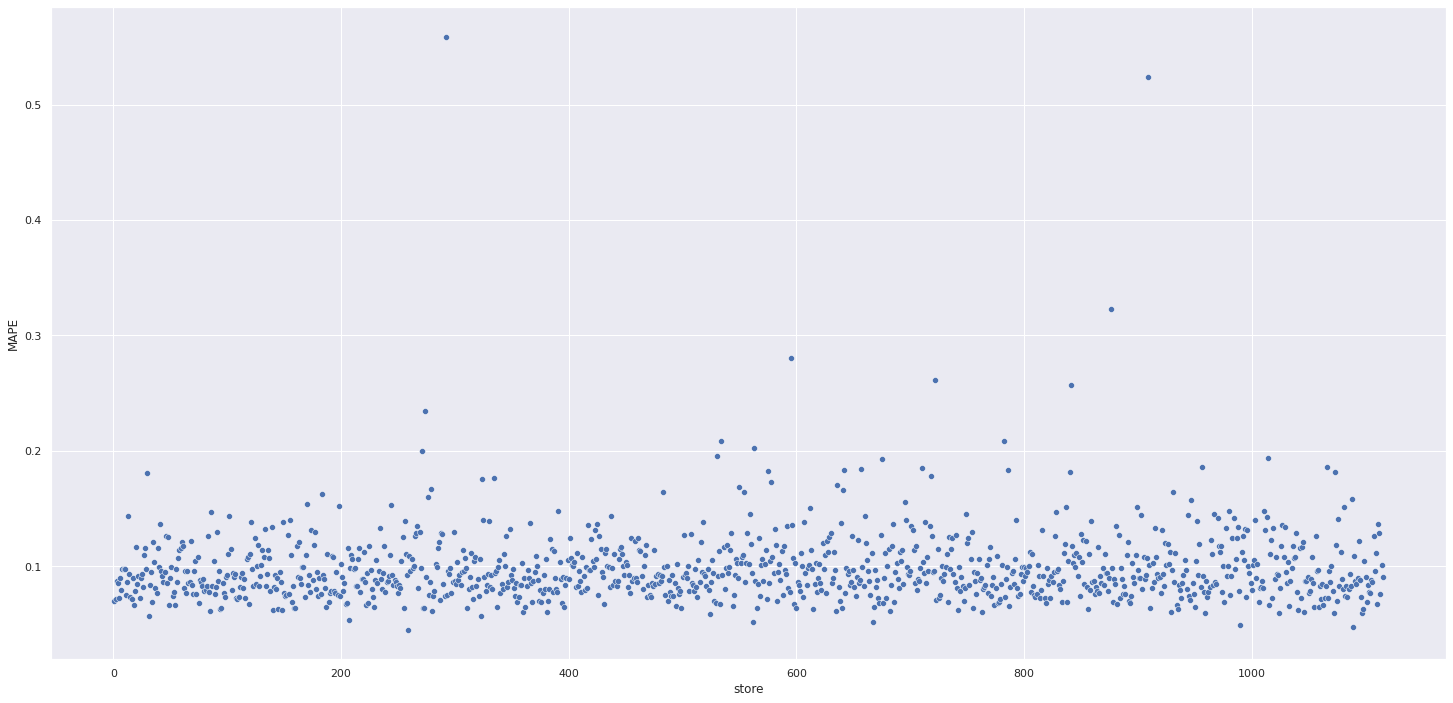

In [82]:
sns.scatterplot(x='store',y='MAPE',data=df9_2);

## 9.2 Total Perfomance

In [83]:
df9_3 = df9_2[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns={'index': 'Scenarios', 0 : 'Values'})
df9_3['Values'] = df9_3['Values'].map('R${:,.2f}'.format)
df9_3

,Scenarios,Values
0,predictions,"R$286,772,224.00"
1,worst_scenario,"R$286,025,344.34"
2,best_scenario,"R$287,519,068.14"


## 9.3 Machine Learning Perfomance

In [203]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

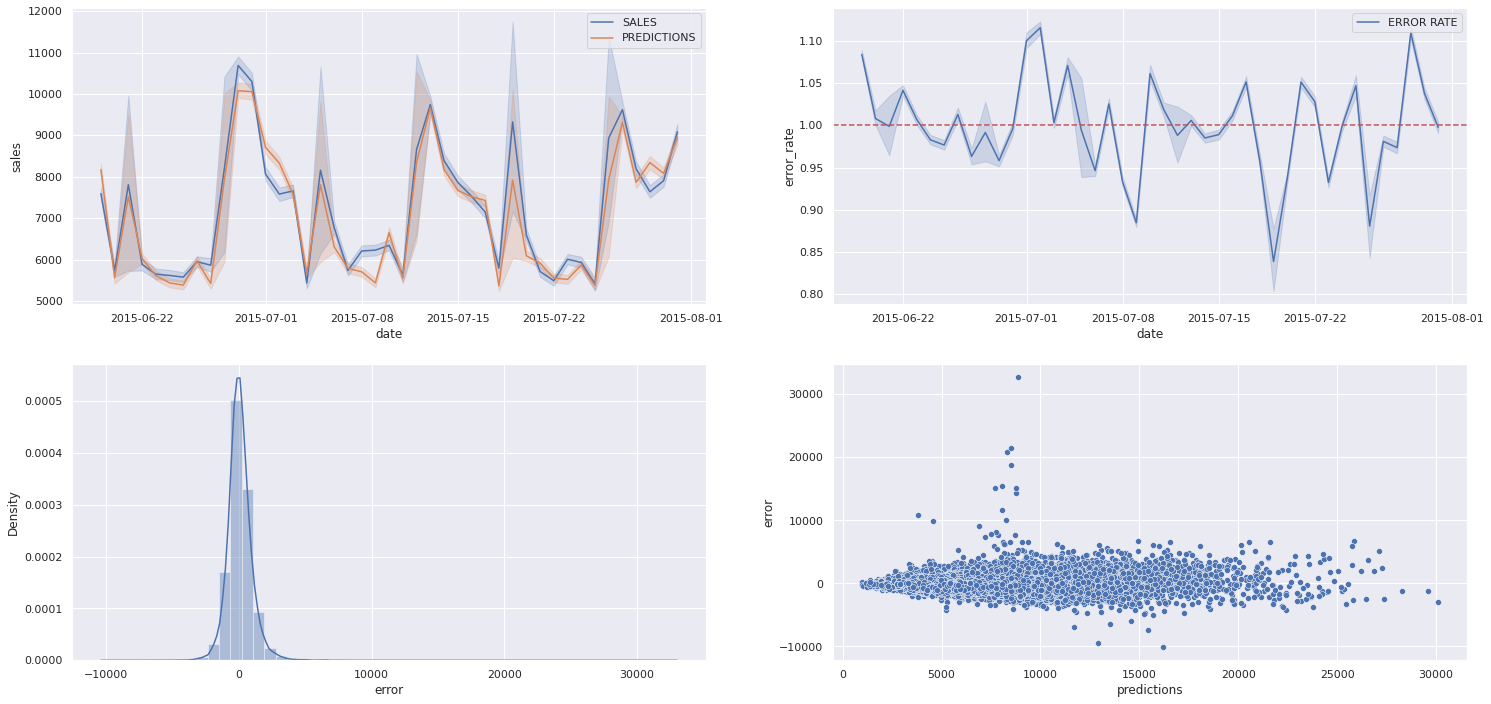

In [205]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES')
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9,label='ERROR RATE')
plt.axhline(1,linestyle='--',color='r')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error'])



# 10.0 Deploy Model to Production

In [ ]:
#pickle.dump(model_xgb_tuned,open('/home/jordanmalheiros/Estudismo/ds_producao/Rossman/model/model_rossman_2500.pkl','wb'))

## 10.1 Rossman Class

In [91]:
class Rossman(object):
    
    def __init__(self):
        self.encoding_competition_distance_scaler   = pickle.load(open('parameter/encoding_competition_distance_scaler.pkl','rb'))
        self.encoding_competition_time_month_scaler = pickle.load(open('parameter/encoding_competition_time_month_scaler.pkl','rb'))
        self.encoding_promo_time_week_scaler        = pickle.load(open('parameter/encoding_promo_time_week_scaler.pkl','rb'))
        self.encoding_year_scaler                   = pickle.load(open('parameter/encoding_encoding_year_scaler.pkl','rb'))
        self.store_type_scaler.pickle               = pickle.load(open('parameter/store_type_scaler.pkl','rb'))
        
        state = 1
        
        
    def data_cleaning(self,df1):
        
        ## 1.1 Rename Columns
        cols_new = ['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
               'state_holiday', 'school_holiday', 'store_type', 'assortment',
               'competition_distance', 'competition_open_since_month',
               'competition_open_since_year', 'promo2', 'promo2_since_week',
               'promo2_since_year', 'promo_interval']
        
        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fill NA
        #competition_distance - Se for tao longe que nao foi computado, colocar um valor mto grande!
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

        #competition_open_since_month  
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

        #promo2_since_week    
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'],axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        #promo_interval
        month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sept',10:'Oct',11:'Nov',12:'Dec'}

        df1['promo_interval'].fillna(0,inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1) 

        ## 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1

    def feature_engineering(self,df1):
        
        ## year
        df1['year'] = df1['date'].dt.year

        ## month
        df1['month'] = df1['date'].dt.month

        ## day
        df1['day'] = df1['date'].dt.day

        ## week of year
        df1['week_of_year'] = df1['date'].dt.weekofyear

        # year week
        df1['year_week'] = df1['date'].dt.strftime('%Y-%W')

        #competition_since
        df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
        df1['competition_time_month'] = ((df1['date'] - df1['competition_since'] ) /30).apply(lambda x: x.days).astype(int)

        #promo_since
        df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
        df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

        df1['promo_time_week'] = ((df1['date'] - df1['promo_since'] ) / 7).apply(lambda x: x.days).astype(int)

        #assortment
        df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state_holiday
        df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        ## 3.1 Filtragem das Linhas
        df1 = df1[(df1['open'] != 0) & (df1['sales'] > 0)]

        ## 3.2 Seleção das Colunas
        cols_drop = ['customers','open','promo_interval','month_map']
        df1 = df1.drop(cols_drop,axis=1)
        
        return df1
    
    
    def data_preparation(self,df5):
        ## 5.2 Reescaling

        rs = RobustScaler()
        mms = MinMaxScaler()

        # competition_distance - ROBUST SCALLER
        df5['competition_distance'] = self.encoding_competition_distance_scaler.fit(df5[['competition_distance']].values)
    
        # competition_time_month - ROBUST SCALLER
        df5['competition_time_month'] = self.encoding_competition_time_month_scaler.fit(df5[['competition_time_month']].values)

        # promo_time_week -  MIN MAX - MinMaxScaler
        df5['promo_time_week'] = self.encoding_promo_time_week_scaler.fit(df5[['promo_time_week']].values)

        # year - MIN MAX
        df5['year'] = self.encoding_year_scaler.fit(df5[['year']].values)

        ## 5.3 Transformação
        ### 5.3.1 Encoding
        #state_holiday - regular / public / easter / christmas - One Hot Encoding
        df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

        #store_type - a b c -> Label Encoding
        df5['store_type'] = self.encoding_store_type_scaler.fit(df5['store_type'])

        #assortment -> basic - extended - extra -> Ordinal Encoding
        assortment_dict = {'basic':1,'extra':2,'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Nature Transformation
        ## month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2* np.pi/12)) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2* np.pi/12)) )

        ## day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2* np.pi/30)) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2* np.pi/30)) )


        ## week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2* np.pi/52)) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2* np.pi/52)) )

        ## day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2* np.pi/7)) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2* np.pi/7)) )
        
        cols_final = ['store',
         'promo',
         'store_type',
         'assortment',
         'competition_distance',
         'competition_open_since_month',
         'competition_open_since_year',
         'promo2',
         'promo2_since_week',
         'promo2_since_year',
         'competition_time_month',
         'promo_time_week',
         'month_sin',              
         'month_cos',
         'day_sin',
         'day_cos',
         'week_of_year_sin',
         'week_of_year_cos',
         'day_of_week_sin',
         'day_of_week_cos']
        
        return df5[cols_final]


## 10.2 API Handler Class

In [93]:
from flask import Flask, request, Response
from rossman.Rossman import Rossman
import pandas as pd
import pickle

# Loading Model
model = picke.load(open('/home/jordanmalheiros/Estudismo/ds_producao/Rossman/model/model_rossman_2500.pkl','rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossman/predict',methods=['POST'])

def rossman_predict():
    test_json = request.get_json()
    
    #There is json?!
    if test_json:
        if isintance(test_json,dict): # Only one example
            test_raw = pd.DataFrame(test_json,index=[0])
        else: # Multiple Exames
            test_raw = pd.DataFrame(test_json,columns=test_json[0].keys())
            
        # Instance Rossman Class
        pipeline = Rossman()
        
        # Data Cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data Preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model,test_raw,df3)
        
        return df_response
        
        
    else:
        return Response('{}',status=200,mimetype='application/json')


    if __name__ == '__main__':
        app.run('0.0.0.0')
        
        
        

KeyboardInterrupt: 

## 10.3 API Tester

In [29]:
df10 = pd.read_csv('/home/jordanmalheiros/Estudismo/ds_producao/Rossman/data/test.csv')

In [30]:
# Merge test dataset + store
df_test = pd.merge(df10,df_store_raw,how='left',on='Store')

# Choose Store for Prediction
#df_test = df_test[df_test['Store'] == 24] 
df_test = df_test[df_test['Store'].isin([7,17,101]) ]


# Remove Closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id',axis=1)

#Convert DF to Json
data = json.dumps(df_test.to_dict(orient='records'))

# API CALL
#url = 'http://0.0.0.0:5000/rossman/predict'
url = 'https://rossman-model-jordanm.herokuapp.com/rossman/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url,data=data,headers=header)

print('Status Code {}'.format(r.status_code))



Status Code 200


In [31]:
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range (len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i,'store'],
            d2.loc[i,'prediction']))

Store Number 7 will sell R$374,041.71 in the next 6 weeks
Store Number 101 will sell R$294,266.79 in the next 6 weeks


In [28]:
d2.head()

,store,prediction
0,10,225464.406982
1,21,229098.996826
